In [2]:
import cv2
import dlib
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image, ImageOps

import time

In [3]:
class EyeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
import os

# print(os.getcwd())
print(os.path.basename("test.py"))
print(os.path.abspath("test.py"))
print(os.path.dirname("../"))

test.py
d:\UofT Winter 2021\APS360\v4\driver-drowsiness-detection-main\driver-drowsiness-detection-main\test.py
..


In [5]:
# Load pre-trained face detector
model_file = "D://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Pretrained Detectors//res10_300x300_ssd_iter_140000.caffemodel"
config_file = "D://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Pretrained Detectors//deploy.prototxt"
face_model = cv2.dnn.readNetFromCaffe(config_file, model_file)

# Load pre-trained landmark predictor
predictor = dlib.shape_predictor("D://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Pretrained Detectors//shape_predictor_68_face_landmarks.dat")

# Load CNN eye classifier
eye_model = EyeClassifier()
eye_model.load_state_dict(torch.load("./Saved Models/model2.pt"))
eye_model.eval()

EyeClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [6]:
# Locates bounding box for a single face
def detect_face(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    face_model.setInput(blob)
    detections = face_model.forward()

    (x1, y1, x2, y2) = 0, 0, 0, 0
    max_confidence = 0

    for i in range(detections.shape[2]):                          
        confidence = detections[0, 0, i, 2]

        if confidence > 0.5 and confidence > max_confidence:      # Only considers predictions with > 0.5 confidence
            (h, w) = img.shape[:2]
            x1 = int(detections[0, 0, i, 3] * w)
            y1 = int(detections[0, 0, i, 4] * h)
            x2 = int(detections[0, 0, i, 5] * w)
            y2 = int(detections[0, 0, i, 6] * h)

            max_confidence = confidence                           # If multiple faces are detected, only return the one with highest confidence

    return dlib.rectangle(x1, y1, x2, y2), max_confidence


# Locates bounding box for a single eye
def detect_eye(img, face):
    landmarks = predictor(img, face)

    if landmarks.num_parts == 0:
        return (0, 0, 0, 0), False
    
    """ Below is some random math I came up with to turn LEFT eye landmarks into a square box, feel free to change"""
    x1 = landmarks.part(17).x                   
    x2 = landmarks.part(21).x
    d = abs(x2-x1)
    k = d * 0.15

    x1 = x1 - int(k/2)
    x2 = x2 + int(k/2)
    y1 = landmarks.part(19).y - int(k/2)
    y2 = y1 + int(d+k)

    return (x1, y1, x2, y2), True

In [7]:
# Prepares an image for CNN eye classifier
def preprocess(img):
    t = transforms.Compose([transforms.Resize([24, 24]), 
                            transforms.ToTensor()]) 
                            
    img = Image.fromarray(img).convert("L")
    img = ImageOps.equalize(img)
    img = t(img)

    return img


# Predicts eye state given a single 1x24x24 tensor
def predict_eye_state(img):
    outputs = eye_model(img.unsqueeze(0))
    prob = F.softmax(outputs, dim = 1)
    pred = outputs.argmax(dim = 1).item()

    #print(f"Probabilities: ({prob[0][0]}, {prob[0][1]})")
    #print("Prediction:", pred)

    return pred

In [24]:
path = "d://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Sample Pictures//open.jpg"
frame = cv2.imread(path)
face, confidence = detect_face(frame)
(x1, y1, x2, y2), eye_found = detect_eye(frame, face)
if eye_found:
    # Eye state classification
    eye = frame[y1:y2, x1:x2]
    eye = preprocess(eye)
    pred = predict_eye_state(eye)
    # perclos_list.append(pred)
    print(pred)
    

1


In [63]:
# Read the KSS file (DROZY Dataset for testing)

f = open("d://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Datasets//DROZY//KSS.txt", "r")
list1 = []
string = f.read()
string_mod = string.replace("\n", ",")
list1 = string_mod.split(",")
for i in range(len(list1)):
    list1[i] = list1[i].split(" ")

print(list1)

def get_kss_drozy(filename, array):
    # Assuming the filename -> "1-2.mp4" or "11-2.mp4"
    if len(filename) == 7:
        index1 = int(filename[0])
        index2 = int(filename[2])
    else:
        index1 = int(filename[1])+10
        index2 = int(filename[4])
    return array[index1][index2]

get_kss_drozy("1-2.mp4", list1)

[['3', '6', '7'], ['3', '7', '6'], ['2', '3', '4'], ['4', '8', '9'], ['3', '7', '8'], ['2', '3', '7'], ['0', '4', '9'], ['2', '6', '8'], ['2', '6', '8'], ['3', '6', '7'], ['4', '7', '7'], ['2', '5', '6'], ['6', '3', '7'], ['5', '7', '8']]


'6'

In [50]:
cap = cv2.VideoCapture("d://UofT Winter 2021//APS360//v4//driver-drowsiness-detection-main//driver-drowsiness-detection-main//Datasets//DROZY/videos_i8//1-2.mp4")    
#cap = cv2.VideoCapture("./Datasets/X/04/5.mp4")   
#cap = cv2.VideoCapture(0)

perclos_list = []
closed_list = []

counter = 0
while cap.isOpened():
    if counter > 1799:
        break
    ret, frame = cap.read()     # return status and image
    if not ret:
        print("Can't retreive frame")
        break
    # print(ret)
    # break

    time.sleep(0.05)             # too see blinks clearly

    # Face detection
    face, confidence = detect_face(frame)
    # print(confidence)
    # break

    if confidence > 0:

        # Eye detection
        (x1, y1, x2, y2), eye_found = detect_eye(frame, face)

        if eye_found:
            # Eye state classification
            eye = frame[y1:y2, x1:x2]
            eye = preprocess(eye)
            pred = predict_eye_state(eye)
            perclos_list.append(pred)

            """ADD KSS IF AND ELSE STATEMENTS"""

            if(pred == 0):
                cv2.putText(frame, "Closed", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
                closed_list.append(pred)

        # Rectangle visuals
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.rectangle(frame, (face.left(), face.top()), (face.right(), face.bottom()), (255, 0, 0), 2)
        confidence_txt = "{:.2f}%".format(confidence * 100)
        cv2.putText(frame, confidence_txt, (face.left(), face.top()), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1)


    # Display frame
    # cv2.imshow("img", frame)

    # Exit window using "q" key
    if cv2.waitKey(1) == ord("q"):
        break
    counter+=1


cap.release()
cv2.destroyAllWindows()

print(len(perclos_list))
print(len(closed_list))

1801
80


In [48]:
print(len(perclos_list))
print(len(closed_list))

17865
1069


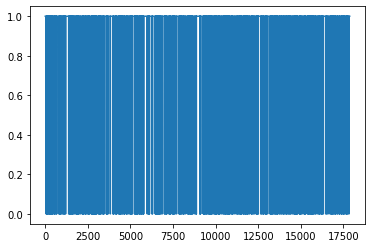

In [49]:
co = 0
len(perclos_list)
from matplotlib import pyplot as plt
plt.plot(perclos_list)
plt.show()

In [42]:
co

# '''
# Hypothesis: Assuming the amount of closure is indicated by the 'pred', the amount of zeros and 
# the amount of values less than 0.8 are the same that is 38. 
# '''

38